### Instructor Demo: Financial Forecasting Part III

This program executes `1000` simulations of stock price trajectory for `TSLA` and `SPHD` over the next `252 * 3` trading days (or 3 years of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `75%` of capital allocated to `TSLA` and `25%` of capital allocated to `SPHD`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '2a5db6a2-c035-46cc-840f-fa519740a9b5',
     'marginable': True,
     'name': 'LifeSci Acquisition Corp. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'LSAC',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': '49b90cdc-f6f5-4a7c-807a-ed172e6017af',
     'marginable': True,
     'name': 'American Express Company',
     'shortable': True,
     'status': 'active',
     'symbol': 'AXP',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': 'f85c0ede-3556-4d0b-9e0c-4ffc2425044d',
     'marginable': True,
     'name': 'Diageo plc',
     'shortable': True,
     'status': 'active',
     'symbol': 'DEO',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'i

### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [4]:
# Set the list of tickers
tickers = ["TSLA", "SPHD"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA and SPHD.
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

SPHD                                   TSLA  \
                            open   high      low  close  volume    open   
2019-05-07 00:00:00-04:00  42.26  42.28  41.7600  42.03  692472  256.80   
2019-05-08 00:00:00-04:00  41.97  42.07  41.7900  41.79  656978  246.94   
2019-05-09 00:00:00-04:00  41.60  41.79  41.3400  41.72  738856  242.00   
2019-05-10 00:00:00-04:00  41.62  42.19  41.3500  42.12  612070  239.75   
2019-05-13 00:00:00-04:00  41.64  41.72  41.3372  41.53  962144  232.01   

                                                                
                              high       low   close    volume  
2019-05-07 00:00:00-04:00  257.210  245.1000  247.06   9542822  
2019-05-08 00:00:00-04:00  250.599  244.2000  244.76   5757805  
2019-05-09 00:00:00-04:00  243.680  236.9434  241.98   6455536  
2019-05-10 00:00:00-04:00  241.990  236.0200  239.51   6716345  
2019-05-13 00:00:00-04:00  232.470  224.5000  227.01  10159046

### Drop Extraneous Columns

In [5]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPHD,TSLA
,close,close
2019-05-07 00:00:00-04:00,42.03,247.06
2019-05-08 00:00:00-04:00,41.79,244.76
2019-05-09 00:00:00-04:00,41.72,241.98
2019-05-10 00:00:00-04:00,42.12,239.51
2019-05-13 00:00:00-04:00,41.53,227.01


### Calculate Daily Returns

In [6]:
# Use the `pct_change` function to calculate daily returns of `TSLA` and `SPHD`.
daily_returns = df.pct_change()
daily_returns.head()

,SPHD,TSLA
,close,close
2019-05-07 00:00:00-04:00,NaN,NaN
2019-05-08 00:00:00-04:00,-0.005710,-0.009309
2019-05-09 00:00:00-04:00,-0.001675,-0.011358
2019-05-10 00:00:00-04:00,0.009588,-0.010207
2019-05-13 00:00:00-04:00,-0.014008,-0.052190


### Calculate Value of Average Daily Returns

In [7]:
# Use the `mean` function to calculate the mean of daily returns for `TLSA` and `SPHD`, respectively
avg_daily_return_tsla = daily_returns.mean()['TSLA']['close']
avg_daily_return_sphd = daily_returns.mean()['SPHD']['close']
avg_daily_return_sphd

-0.0009731255505767599

### Calculate Value of Standard Deviation of Daily Returns

In [8]:
# Use the `std` function to calculate the standard deviation of daily returns for `TSLA` and `SPHD`, respectively
std_dev_daily_return_tsla = daily_returns.std()['TSLA']['close']
std_dev_daily_return_sphd = daily_returns.std()['SPHD']['close']
std_dev_daily_return_sphd

0.02186408585403397

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [9]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252 * 3

# Set last closing prices of `TSLA` and `SPHD`
tsla_last_price = df['TSLA']['close'][-1]
sphd_last_price = df['SPHD']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_tsla_prices = [tsla_last_price]
    simulated_sphd_prices = [sphd_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_tsla_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return_tsla, std_dev_daily_return_tsla))
        simulated_sphd_price = simulated_sphd_prices[-1] * (1 + np.random.normal(avg_daily_return_sphd, std_dev_daily_return_sphd))
        
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_tsla_price)
        simulated_sphd_prices.append(simulated_sphd_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["TSLA prices"] = pd.Series(simulated_tsla_prices)
    simulated_price_df["SPHD prices"] = pd.Series(simulated_sphd_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (75% TSLA; 25% SPHD)
    weights = [0.25, 0.75]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.971417,0.990266,0.996465,1.006905,1.000647,0.981071,1.015728,0.988290,1.015624,1.041992,...,1.023273,0.981602,1.012649,0.981425,0.995801,1.017698,1.004749,1.027175,0.978023,1.002023
2,0.978446,0.988574,0.992406,0.998475,0.966427,0.991609,1.010437,0.967503,1.009248,1.046185,...,1.006000,0.960281,1.025751,0.982718,1.001921,1.014265,1.001219,1.040359,0.957587,0.984278
3,0.965225,0.971785,0.985264,1.016349,0.975548,0.989119,0.985443,0.959758,1.014336,1.081424,...,1.031983,0.979614,1.012328,0.994811,1.019286,1.009479,1.004488,1.052060,0.951749,0.939824
4,0.989280,0.975855,1.021459,1.004754,0.994515,0.998577,0.978688,0.978320,0.985043,1.105678,...,1.064659,1.014796,1.055745,0.994802,1.025717,1.013671,0.984051,1.025874,0.977658,0.932271


### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next 3 Years (252 * 3 Trading Days)

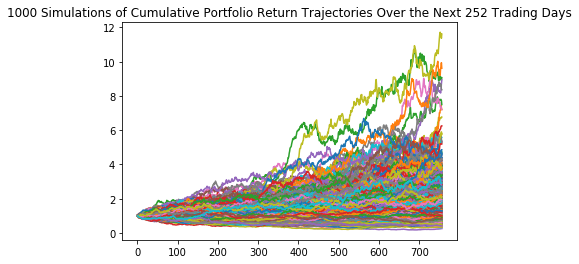

In [10]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [11]:
# Select the last row for projecting stock prices (prices of each simulation on the last trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    1.941331
1    1.234238
2    0.941042
3    2.965512
4    3.000325
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the Last Trading Day

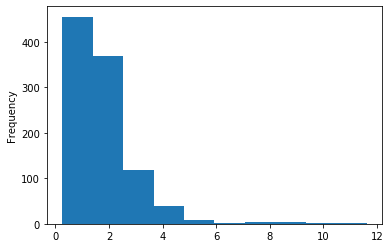

In [12]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [13]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(0.244, 1.392]      0.455
(1.392, 2.528]      0.368
(2.528, 3.663]      0.119
(3.663, 4.799]      0.039
(4.799, 5.935]      0.009
(8.206, 9.341]      0.003
(7.07, 8.206]       0.003
(5.935, 7.07]       0.002
(10.477, 11.613]    0.001
(9.341, 10.477]     0.001
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [14]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.511542
0.975    4.421008
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

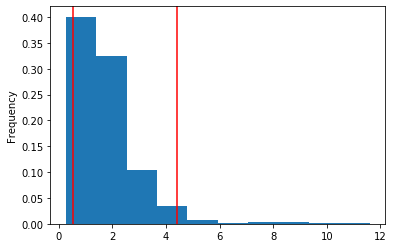

In [15]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 3 Trading Years

In [16]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment * confidence_interval.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval.iloc[1]
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 * 3 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $5115.418234015097 and $44210.078230727355


### Answer the Following Questions

* What is the expected range of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative investment for the given portfolio?

* The expected range of projected cumulative returns for the portfolio is between 0.671 and 0.833 with a 24.2% chance of occurring.
* The `95` confidence interval of projected cumulative returns is between 0.514393 and 1.570911.
* The `95` confidencc interval of projected cumulative investment is between 5143.93 and 15709.11.